# Project 3

In [1]:
#Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
# from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Data Collection and Cleaning

In [2]:
#grabbing data limit 5000 posts/fixed my issue here before
def get_data(subreddit):
    data = []
    url =f'https://api.pushshift.io/reddit/search/submission?subreddit={subreddit}'
    req = requests.get(url).json()
    while len(data) <= 5000:
            data.extend(req['data'])
    return data

In [3]:
nfl_posts = get_data("nfl")
bb_posts = get_data("baseball")

In [4]:
nfl_df = pd.DataFrame(nfl_posts)

bb_df=pd.DataFrame(bb_posts)

In [5]:
nfl_df=nfl_df[['subreddit','title','selftext',]]

In [6]:
bb_df=bb_df[['subreddit','title','selftext',]]
bb_df

,subreddit,title,selftext
0,baseball,"Arizona hangs it, LaMonte Wade Jr. bangs it ve...",
1,baseball,[Divish] John Tumpane's called strike three on...,
2,baseball,Kyle Gibson 5.2 IP 7SO 3BB 5H ERA at 1.98 in l...,Kyle didn't have his best stuff tonight but ba...
3,baseball,Kike Hernandez drives in the Manfred runner to...,
4,baseball,Why would a team shift largely toward the 1st ...,I’m currently watching the Giants/D-Backs game...
...,...,...,...
5020,baseball,[Hightlight] José Rondón ties the game in the ...,
5021,baseball,Red Hats,"As a Rays fan, confrontational"
5022,baseball,"[Niehaus] Will Bednar, hours after the Nationa...",
5023,baseball,"For the first time in 10 days, the Royals have...","No, we are still really straight up not having..."


In [7]:
nfl_df = pd.DataFrame(nfl_df)

In [8]:
bb_df = pd.DataFrame(bb_df)

In [9]:
nfl_df.isnull().sum()

subreddit    0
title        0
selftext     0
dtype: int64

In [10]:
bb_df.isnull().sum()

subreddit    0
title        0
selftext     0
dtype: int64

In [11]:
final_df=pd.concat([nfl_df, bb_df])
final_df["post"] = final_df["title"] +' '+ final_df["selftext"]

In [12]:
final_df['post'].dropna(inplace=True)

In [13]:
final_df['subreddit']

0            nfl
1            nfl
2            nfl
3            nfl
4            nfl
          ...   
5020    baseball
5021    baseball
5022    baseball
5023    baseball
5024    baseball
Name: subreddit, Length: 10050, dtype: object

Pre-processing

In [14]:
final_df['subreddit'] = final_df['subreddit'].map({'nfl': 0, 'baseball': 1})

In [15]:
final_df["post"].shape

(10050,)

In [16]:
#class notes
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()
lemm = []
stemm = []
for t in final_df['post']:
    tokens = tokenizer.tokenize(t.lower())
    tokens_lem = [lemmatizer.lemmatize(l) for l in tokens]
    lemm.append(tokens_lem)
    tokens_stemm = [p_stemmer.stem(s) for s in tokens]
    stemm.append(tokens_stemm) 

In [17]:
final_df

,subreddit,title,selftext,post
0,0,Ezekiel Elliott leads the NFL in yards from sc...,https://www.statmuse.com/nfl/ask/who-has-the-m...,Ezekiel Elliott leads the NFL in yards from sc...
1,0,Since 2016 Ezekiel Eliiott leads the league in...,,Since 2016 Ezekiel Eliiott leads the league in...
2,0,"[Highlights] One year ago today, we lost a leg...",,"[Highlights] One year ago today, we lost a leg..."
3,0,[Highlights] 1982- The Bengals and Chargers ri...,,[Highlights] 1982- The Bengals and Chargers ri...
4,0,[B/R] Percy Harvin on coping with anxiety duri...,,[B/R] Percy Harvin on coping with anxiety duri...
...,...,...,...,...
5020,1,[Hightlight] José Rondón ties the game in the ...,,[Hightlight] José Rondón ties the game in the ...
5021,1,Red Hats,"As a Rays fan, confrontational","Red Hats As a Rays fan, confrontational"
5022,1,"[Niehaus] Will Bednar, hours after the Nationa...",,"[Niehaus] Will Bednar, hours after the Nationa..."
5023,1,"For the first time in 10 days, the Royals have...","No, we are still really straight up not having...","For the first time in 10 days, the Royals have..."


In [18]:
X = final_df['post']
y = final_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

In [19]:
#add_stop_words
add_stop_words = ['team', 'teams', 'game', 'just', 'like', 'league', 'com','www','https' ]
stop_words = (CountVectorizer(ngram_range =(1,1), stop_words='english').get_stop_words())
stop_words = stop_words.union(add_stop_words)

In [20]:
cvec= CountVectorizer(stop_words = stop_words)

In [21]:
X_train = cvec.fit_transform(X_train)

In [22]:
X_test = cvec.transform(X_test)

# EDA

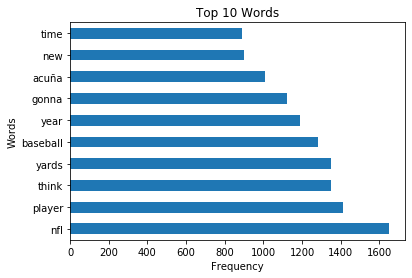

In [23]:
top_words = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())
top_words.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Top 10 Words');

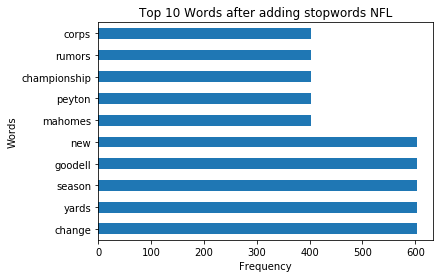

In [24]:
cv_nfl=pd.DataFrame(cvec.fit_transform(nfl_df['selftext']).todense(),
             columns=cvec.get_feature_names())
cv_nfl.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Top 10 Words after adding stopwords NFL');

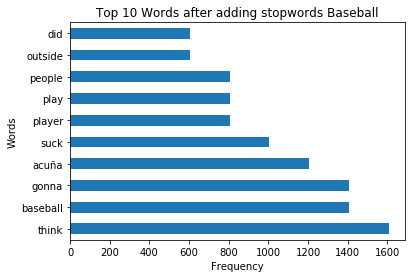

In [25]:
bb_df2=pd.DataFrame(cvec.fit_transform(bb_df['selftext']).todense(),
             columns=cvec.get_feature_names())
bb_df2.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Top 10 Words after adding stopwords Baseball');

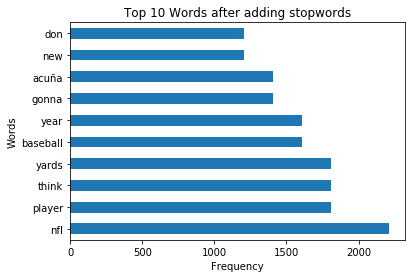

In [26]:
cv_df=pd.DataFrame(cvec.fit_transform(final_df['post']).todense(),
             columns=cvec.get_feature_names())
cv_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Top 10 Words after adding stopwords');

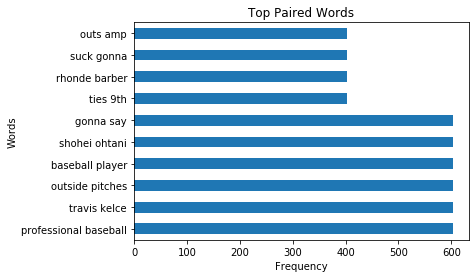

In [27]:
#got some help from classmates on the paired words, went back and changed my initial working code to clean
cv_words = CountVectorizer(ngram_range =(2,2), stop_words=stop_words)

cv_df=pd.DataFrame(cv_words.fit_transform(final_df['post']).todense(),
             columns=cv_words.get_feature_names())
       
cv_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');


plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Top Paired Words');

# MODELS

In [28]:
#baseline
y.value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

Model 1

In [29]:
X = final_df['post']
y = final_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

In [30]:
count = 0
model_params = {}
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('lg', LogisticRegression(penalty="none"))
])
pipe_params = {
    'cvec__max_features': [2_000],
    'cvec__min_df': [1],
    'cvec__max_df': [.7],
    'cvec__ngram_range': [(1,2)]
}
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)
gs.fit(X_train, y_train)
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score
model_0,0.7,2000,1,"(1, 2)",1.0


In [31]:
print(gs.cv_results_)

{'mean_fit_time': array([0.32552266]), 'std_fit_time': array([0.03884966]), 'mean_score_time': array([0.09379725]), 'std_score_time': array([0.02171193]), 'param_cvec__max_df': masked_array(data=[0.7],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_cvec__max_features': masked_array(data=[2000],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_cvec__min_df': masked_array(data=[1],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_cvec__ngram_range': masked_array(data=[(1, 2)],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'cvec__max_df': 0.7, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'score': 1.0}], 'split0_test_score': array([1.]), 'split1_test_score': array([1.]), 'split2_test_score': array([1.]), 'split3_test_score': array([1.]), 'split4_test_score': array([1.]), 'mean_test_score': array([1.]), 'std_test

In [32]:
print(gs.best_estimator_)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.7,
                                 max_features=2000, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'a...
                                                       'anywhere', ...}),
                                 strip_accents=None,
                                 token_pattern='(?

In [33]:
print(gs.best_params_)

{'cvec__max_df': 0.7, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'score': 1.0}


In [34]:
print(gs.best_score_)

1.0


In [35]:
gs.score(X_train, y_train)

1.0

In [36]:
gs.score(X_test, y_test)

1.0

In [37]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [38]:
spec = tn / (tn + fp)
print('Specificity:', spec)

Specificity: 1.0


Text(0.5, 1.0, 'Confusion matrix CountVec/LogR')

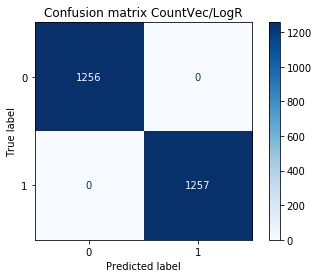

In [39]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Confusion matrix CountVec/LogR')

Model 2

In [40]:
count = 0
model_params = {}
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('lg', LogisticRegression(penalty="none"))
])
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__ngram_range': [(1,1), (1,2)]
}
gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params, 
                        cv=5) 
gs_tvec.fit(X_train, y_train)
gs_tvec.best_params_['score'] = gs_tvec.best_score_
model_params[f'model_{count}'] = gs_tvec.best_params_
model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

,tvec__max_features,tvec__ngram_range,score
model_0,2000,"(1, 1)",1.0


In [41]:
print(gs_tvec.cv_results_)

{'mean_fit_time': array([0.1992682 , 0.30151839, 0.20044131, 0.34128885, 0.21539278,
       0.32159338, 0.27847385, 0.30642219]), 'std_fit_time': array([0.00912868, 0.02141878, 0.01788509, 0.03112727, 0.02502129,
       0.06346748, 0.04816944, 0.02171006]), 'mean_score_time': array([0.04548883, 0.0701005 , 0.04746666, 0.09463334, 0.04722157,
       0.07180891, 0.06109633, 0.07475591]), 'std_score_time': array([0.0028235 , 0.00233789, 0.00687795, 0.02143892, 0.00261038,
       0.00346164, 0.01131784, 0.0044866 ]), 'param_tvec__max_features': masked_array(data=[2000, 2000, 3000, 3000, 4000, 4000, 5000, 5000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_tvec__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 1), (1, 2), (1, 1), (1, 2), (1, 1),
                   (1, 2)],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'pa

In [42]:
print(gs_tvec.best_estimator_)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=2000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards...
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),


In [43]:
print(gs_tvec.best_params_)

{'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'score': 1.0}


In [44]:
print(gs_tvec.best_score_)

1.0


In [45]:
gs_tvec.score(X_train, y_train)

1.0

In [46]:
gs_tvec.score(X_test, y_test)

1.0

In [47]:
preds_tvec = gs_tvec.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()
spec = tn / (tn + fp)
print('Specificity:', spec)

Specificity: 1.0


Text(0.5, 1.0, 'Confusion matrix Tfidf/LogR')

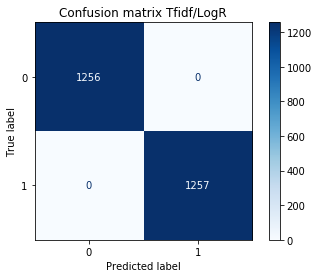

In [48]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Confusion matrix Tfidf/LogR')

Model 3

In [49]:
model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df
count = 0
model_params = {}
pipe_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words, ngram_range = (1,3))),
    ('rf', RandomForestClassifier())
])
pipe_rf_params = {
    'cvec__max_features': [None, 'auto'],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    #'n_estimators': [100, 150, 200],
#    'max_depth': [None, 1, 2, 3],
}
rf = GridSearchCV(pipe_rf,
                  param_grid=pipe_rf_params,
                  cv=5)
rf.fit(X_train, y_train)
rf.best_params_['score'] = rf.best_score_
model_params[f'model_{count}'] = rf.best_params_
model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

/home/andrew/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

  FitFailedWarning)
/home/andrew/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

  FitFailedWarning)


,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score
model_0,0.9,None,2,"(1, 1)",1.0


In [50]:
print(rf.cv_results_)

{'mean_fit_time': array([0.45569859, 0.57628536, 0.49541917, 0.60321174, 0.21711025,
       0.36845326, 0.25003843, 0.27264652, 0.53028564, 0.66480622,
       0.4682168 , 0.692205  , 0.16789832, 0.24408574, 0.17149978,
       0.25039282]), 'std_fit_time': array([0.01907583, 0.00848317, 0.02964514, 0.01643864, 0.04266556,
       0.07760009, 0.0377489 , 0.0102704 , 0.03640345, 0.04611524,
       0.0192981 , 0.03545527, 0.01245372, 0.01464928, 0.00893309,
       0.01442683]), 'mean_score_time': array([0.0753448 , 0.09853492, 0.0741179 , 0.09914045, 0.        ,
       0.        , 0.        , 0.        , 0.08150587, 0.10216403,
       0.0703485 , 0.12204962, 0.        , 0.        , 0.        ,
       0.        ]), 'std_score_time': array([0.01240146, 0.00555157, 0.00415233, 0.00569935, 0.        ,
       0.        , 0.        , 0.        , 0.00690403, 0.01003926,
       0.00492709, 0.0408737 , 0.        , 0.        , 0.        ,
       0.        ]), 'param_cvec__max_df': masked_array(data=[

In [51]:
print(rf.best_estimator_)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'a...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                             

In [52]:
print(rf.best_params_)

{'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'score': 1.0}


In [53]:
print(rf.best_score_)

1.0


In [54]:
gs.score(X_train, y_train)

1.0

In [55]:
gs.score(X_test, y_test)

1.0

In [56]:
preds_df = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_df).ravel()
spec = tn / (tn + fp)
print('Specificity:', spec)

Specificity: 1.0


Text(0.5, 1.0, 'Confusion matrix CountVec/Random Forest')

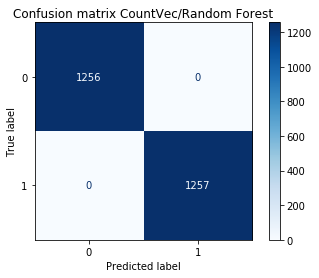

In [57]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Confusion matrix CountVec/Random Forest')

Model 4

In [58]:
count = 0
model_params = {}
pipe_rftv = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('rf', RandomForestClassifier())
])
pipe_rftv_params= {
    'tvec__max_features': [4_000,5000],
    'tvec__ngram_range': [(1,1)],
#     'n_estimators': [100, 150, 200],
#     'max_depth': [None, 1, 2, 3],
}
rf_tvec = GridSearchCV(pipe_rftv, 
                        param_grid = pipe_rftv_params,
                        cv=5,
                        verbose=1)
rf_tvec.fit(X_train, y_train)
rf_tvec.best_params_['score'] = rf_tvec.best_score_
model_params[f'model_{count}'] = rf_tvec.best_params_
model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


,tvec__max_features,tvec__ngram_range,score
model_0,4000,"(1, 1)",1.0


In [59]:
print(rf_tvec.cv_results_)

{'mean_fit_time': array([0.51779971, 0.43692679]), 'std_fit_time': array([0.0541906 , 0.00354465]), 'mean_score_time': array([0.07605305, 0.06839061]), 'std_score_time': array([0.00692699, 0.00105226]), 'param_tvec__max_features': masked_array(data=[4000, 5000],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_tvec__ngram_range': masked_array(data=[(1, 1), (1, 1)],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1), 'score': 1.0}, {'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1)}], 'split0_test_score': array([1., 1.]), 'split1_test_score': array([1., 1.]), 'split2_test_score': array([1., 1.]), 'split3_test_score': array([1., 1.]), 'split4_test_score': array([1., 1.]), 'mean_test_score': array([1., 1.]), 'std_test_score': array([0., 0.]), 'rank_test_score': array([1, 1], dtype=int32)}


In [60]:
print(rf_tvec.best_estimator_)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=4000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                               

In [61]:
print(rf_tvec.best_params_)

{'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1), 'score': 1.0}


In [62]:
print(rf_tvec.best_score_)

1.0


In [63]:
rf_tvec.score(X_train, y_train)

1.0

In [64]:
rf_tvec.score(X_test, y_test)

1.0

In [65]:
preds_rf = rf_tvec.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()
spec = tn / (tn + fp)
print('Specificity:', spec)

Specificity: 1.0


Text(0.5, 1.0, 'Confusion matrix Tf-idf/Random Forest')

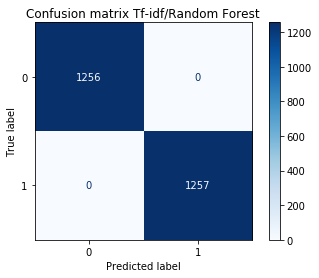

In [66]:
plot_confusion_matrix(rf_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Confusion matrix Tf-idf/Random Forest')

# Evaluation

I had some issues with this model, I will revist my mistakes after discussing with my instructors. Fixed the issue with the amounts of posts being grabbed but not sure why all my models are producing the same output.

Ran the models multiple times with multiple different outputs. Could keep a random state however was working on fixing other breaks.


Our first model scored the best, CountVectorizer Logistic Regresssion. The accuracy score was 100.0% on training data and about 96-100% on testing/new data. We are confident in our model with such a high accuracy however there is no such thing as a perfect model. We will revisit our models to see if there were any parameters we could refine.



Model 1: 0.9689
Model 2: 0.9688
Model 3: 0.9649
Model 4: 0.9611

# Recommendations

There is no such thing as the perfect model however this model is predicting perfect accuracy, is this correct? What could be causing this and why?
Is this our best model or can we make it better?
Improve our model by collecting more data, better data refining, and including more models ie. boosting, SVM.
Sentiment analysis could also be helpful to better determine negative sentiment for betting odds.